# All-optical control

## Preamble

In [1]:
import brian2 as b2
from brian2 import np
import cleo
from cleo import opto, imaging, light
import matplotlib.pyplot as plt

# for reproducibility
rng = np.random.default_rng(92)
np.random.seed(92)

# cleo.utilities.style_plots_for_docs()
plt.style.use('seaborn-paper')

WARNING    /tmp/ipykernel_2795/4042907626.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')
 [py.warnings]


## Brian network setup
All we need are LIF neurons that will spike in response to photostimulation for us to see the resulting fluorescence traces.

In [2]:
ng = b2.NeuronGroup(
    500,
    """dv/dt = (-(v - E_L) + Rm*Iopto) / tau_m : volt
    Iopto : amp""",
    threshold="v > -50*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * b2.ms,
        "Rm": 500 * b2.Mohm,
        "E_L": -70 * b2.mV,
    },
)
ng.v = -70 * b2.mV
cleo.coords.assign_coords_rand_rect_prism(ng, [-0.1, 0.1], [-0.1, 0.1], [0, 0.2])
sim = cleo.CLSimulator(b2.Network(ng))

## Microscope configuration

In [3]:
scope = imaging.Scope(
    focus_depth=100 * b2.um,
    img_width=150 * b2.um,
    sensor=imaging.gcamp6f(),
)
# variable expression
rho_rel_gen = lambda n: rng.lognormal(0, 0.2, size=n)
sim.inject(scope, ng, rho_rel_generator=rho_rel_gen)
scope.n

20

(<Figure size 640x440 with 1 Axes>,
 <Axes3D: xlabel='x (um)', ylabel='y (um)', zlabel='z (um)'>)

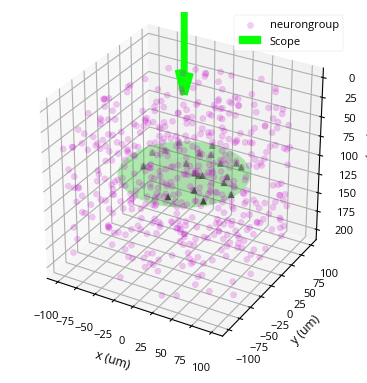

In [4]:
cleo.viz.plot(ng, colors=['#c500cc'], sim=sim)

In [5]:
i_targets = scope.i_targets_for_neuron_group(ng)
scope.n

20

In [6]:
scope.inject_sensor_for_targets()

## 2p stimulation configuration

In [7]:
opsin = opto.vfchrimson_4s()
opsin.spectrum.append((1060, .01))
sim.inject(opsin, ng)

CLSimulator(io_processor=None, devices={GECI(sim=..., name='gcamp6f', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\n\n            CaB_active = Ca_rest + b : mmolar  # add tiny bit to avoid /0\n            db/dt = beta : mmolar (clock-driven)\n            lam = 1/tau_off + 1/tau_on : 1/second\n            kap = 1/tau_off : 1/second\n            dbeta/dt = (                    # should be M/s/s\n                A * (lam - kap) * (Ca - Ca_rest)  # M/s/s\n                - (kap + lam) * beta        # M/s/s\n                - kap * lam * b    # M/s/s\n            ) : mmolar/second (clock-driven)\n            \nexc_factor = 1 : 1\n\n            dFF_baseline = 1 / (1 + (K_d / Ca_rest) ** n_H) : 1\n            dFF = exc_factor * rho_rel * dFF_max  * (\n                1 / (1 + (K_d / CaB_active) ** n_H)\n                - dFF_baseline\n            ) : 1\n          

In [8]:
laser = light.tp_light_from_scope(scope, wavelength=1060*b2.nmeter, name='laser')
sim.inject(laser, ng)

CLSimulator(io_processor=None, devices={GECI(sim=..., name='gcamp6f', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\n\n            CaB_active = Ca_rest + b : mmolar  # add tiny bit to avoid /0\n            db/dt = beta : mmolar (clock-driven)\n            lam = 1/tau_off + 1/tau_on : 1/second\n            kap = 1/tau_off : 1/second\n            dbeta/dt = (                    # should be M/s/s\n                A * (lam - kap) * (Ca - Ca_rest)  # M/s/s\n                - (kap + lam) * beta        # M/s/s\n                - kap * lam * b    # M/s/s\n            ) : mmolar/second (clock-driven)\n            \nexc_factor = 1 : 1\n\n            dFF_baseline = 1 / (1 + (K_d / Ca_rest) ** n_H) : 1\n            dFF = exc_factor * rho_rel * dFF_max  * (\n                1 / (1 + (K_d / CaB_active) ** n_H)\n                - dFF_baseline\n            ) : 1\n          

## 3D view

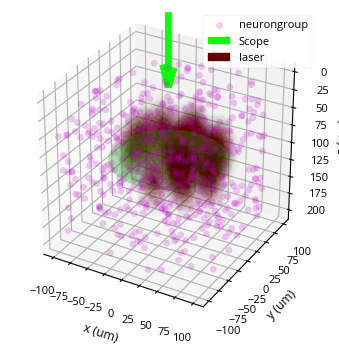

In [29]:
fig, ax = cleo.viz.plot(ng, colors=['#c500cc'], sim=sim, figsize=(4, 4), scatterargs={'rasterized': True})
fig.savefig('img/fig/all-optical-3d.svg', bbox_inches='tight', transparent=True)

## 2D scope view

In [10]:
import seaborn as sns

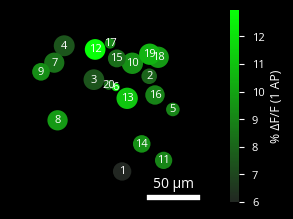

In [91]:
# anchored size bar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.collections import EllipseCollection

with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))
    x, y = ng.x[i_targets] / b2.um, ng.y[i_targets] / b2.um
    lim = scope.img_width * 1.2 / b2.um / 2
    ax.set(xlim=(-lim, lim), ylim=(-lim, lim), aspect="equal")

    perp_dist = np.abs(ng.z[i_targets] - scope.focus_depth)
    r_visible = np.sqrt(scope.soma_radius**2 - perp_dist**2)
    r_visible_um = r_visible / b2.um
    cmap = sns.dark_palette("xkcd:fluorescent green", as_cmap=True)
    rois = EllipseCollection(
        r_visible_um * 2,
        r_visible_um * 2,
        0,
        units="xy",
        offsets=np.c_[x, y],
        offset_transform=ax.transData,
        cmap=cmap,
    )
    rois.set_array(100 * scope.dFF_1AP)
    ax.add_collection(rois)
    # easier, more accurate with EllipseCollection
    # r_visible_pt = r_visible / scope.img_width * ax.bbox.width
    # markerarea = np.pi * r_visible_pt**2
    # rois = ax.scatter(x, y, s=markerarea, c=scope.dFF_1AP, cmap=cmap)

    scale_um = 50
    ax.add_artist(
        AnchoredSizeBar(
            ax.transData,
            scale_um,
            f"{scale_um} µm",
            "lower right",
            frameon=False,
            color="w",
            label_top=True,
            size_vertical=scale_um / 10,
        )
    )
    ax.set_axis_off()
    # annotate each neuron with its index
    for i_img, (x_, y_) in enumerate(zip(x, y)):
        ax.annotate(
            i_img + 1,
            (x_, y_),
            # (x_ + 15, y_),
            color="w",
            ha="center",
            va="center",
            annotation_clip=False,
            fontsize=8,
        )

    cbar = fig.colorbar(rois, label="% ΔF/F (1 AP)", drawedges=False, pad=0.1)
    cbar.outline.set_visible(False)
    # cbar.ax.yaxis.set_ticks([])
    fig.savefig('img/fig/all-optical-2d.svg', bbox_inches='tight')

## Stimulating one at a time; on- vs. off-target effects

In [12]:
from cleo.ioproc import LatencyIOProcessor

# for seeing ground-truth spikes
smon = b2.SpikeMonitor(ng, record=i_targets)
sim.network.add(smon)

amplitude_mW = 2.5
pulse_width_ms = 2
interpulse_ms = 10
t_stim_onset_ms = 100
num_pulses = 10
t_stim_end_ms = t_stim_onset_ms + interpulse_ms * num_pulses
t_end_ms = 800

class IOProc(LatencyIOProcessor):
    i: int

    def process(self, state_dict, time_ms):
        t_in_cycle = time_ms % interpulse_ms
        on = (
            (t_in_cycle < pulse_width_ms)
            & (time_ms >= t_stim_onset_ms)
            & (time_ms < t_stim_end_ms)
        )
        power = np.zeros(scope.n)
        power[self.i] = on * amplitude_mW

        return {"laser": power}, time_ms


sim.set_io_processor(IOProc(1))

dFFs = []
n_targets = scope.n
# n_targets = 5
for i_img in range(n_targets):
    sim.reset()
    sim.io_processor.i = i_img
    sim.run(t_end_ms * b2.ms)
    dFFs.append(np.array(scope.dFF)[::10, :])  # downsample from 1000 to 100 Hz
    n_spks_i = smon.count[i_targets[i_img]]

    print(f'ROI {i_img+1} spiked {n_spks_i} times. Other ROIs spiked {len(smon.t) - n_spks_i} times')

t_ms = np.array(scope.t_ms)[::10]

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_VfChrimson_neurongroup', using method 'euler' (took 0.03s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_gcamp6f_neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]


ROI 1 spiked 15 times. Other ROIs spiked 13 times
ROI 2 spiked 15 times. Other ROIs spiked 8 times
ROI 3 spiked 15 times. Other ROIs spiked 11 times
ROI 4 spiked 15 times. Other ROIs spiked 5 times
ROI 5 spiked 15 times. Other ROIs spiked 10 times
ROI 6 spiked 15 times. Other ROIs spiked 13 times
ROI 7 spiked 15 times. Other ROIs spiked 4 times
ROI 8 spiked 15 times. Other ROIs spiked 8 times
ROI 9 spiked 15 times. Other ROIs spiked 0 times
ROI 10 spiked 15 times. Other ROIs spiked 0 times
ROI 11 spiked 15 times. Other ROIs spiked 3 times
ROI 12 spiked 15 times. Other ROIs spiked 5 times
ROI 13 spiked 15 times. Other ROIs spiked 13 times
ROI 14 spiked 15 times. Other ROIs spiked 0 times
ROI 15 spiked 15 times. Other ROIs spiked 6 times
ROI 16 spiked 15 times. Other ROIs spiked 18 times
ROI 17 spiked 15 times. Other ROIs spiked 2 times
ROI 18 spiked 15 times. Other ROIs spiked 15 times
ROI 19 spiked 15 times. Other ROIs spiked 12 times
ROI 20 spiked 15 times. Other ROIs spiked 16 times


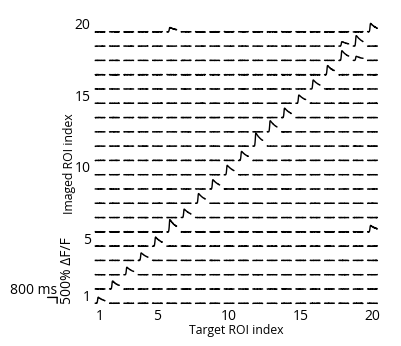

In [31]:
# one axis much faster than a subplot grid
fig, ax = plt.subplots(figsize=(4, 4))
dFFs_arr = np.array(dFFs)
x_space = t_end_ms * 1.5
x_offsets = np.arange(n_targets) * x_space
y_space = np.max(dFFs_arr) * 1.1
y_offsets = np.arange(n_targets) * y_space

for i_target in range(n_targets):
    for i_img in range(n_targets):
        ax.plot(
            t_ms + x_offsets[i_target],
            dFFs_arr[i_target, :, i_img] + y_offsets[i_img],
            c="k",
            rasterized=True,
            lw=1,
        )
# ax.set_axis_off()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set(yticks=[], xticks=[])

#################### scale bars ######################
y_scale = 5
x_scale = t_end_ms
y0 = 0
x0 = -4 * t_end_ms
# y (dF/F) scale bar
ax.annotate(
    "",
    xy=(x0, y0),
    xytext=(x0, y0 + y_scale),
    arrowprops=dict(arrowstyle="-", lw=1, shrinkA=0, shrinkB=0),
    annotation_clip=False,
    xycoords="data",
)
ax.annotate(
    f"{y_scale * 100}% ΔF/F",
    xy=(x0 + 200, y0),
    va="bottom",
    ha="left",
    rotation=90,
    annotation_clip=False,
)
# x (time) scale bar
ax.annotate(
    "",
    xy=(x0, y0 + y_scale),
    xytext=(x0 - x_scale, y0 + y_scale),
    arrowprops=dict(arrowstyle="-", lw=1, shrinkA=0, shrinkB=0),
    annotation_clip=False,
)
ax.annotate(
    f"{x_scale} ms",
    xy=(x0, y0 + y_scale),
    va="bottom",
    ha="right",
    annotation_clip=False,
)

#################### label ROI indices ######################
for i_target in range(n_targets):
    i_lbl = i_target + 1
    if i_lbl == 1 or i_lbl % 5 == 0:
        ax.annotate(
            i_lbl,
            xy=(x_offsets[i_target] + t_end_ms / 2, -4),
            xycoords="data",
            va="top",
            ha="center",
            annotation_clip=False,
        )

for i_img in range(n_targets):
    i_lbl = i_img + 1
    if i_lbl == 1 or i_lbl % 5 == 0:
        ax.annotate(
            i_lbl,
            xy=(-400, y_offsets[i_img] + dFFs_arr.max() / 2),
            xycoords="data",
            va="center",
            ha="right",
            annotation_clip=False,
        )

ax.set(xlabel='Target ROI index', ylabel='Imaged ROI index')

fig.savefig("img/fig/all-optical-traces.svg", bbox_inches="tight", dpi=300, transparent=True)

## Gaussian point spread function

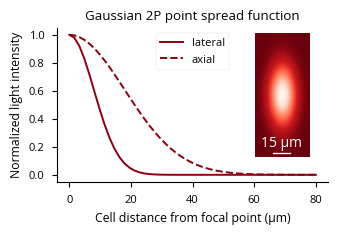

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sigma_r = laser.light_model.sigma_lateral
sigma_z = laser.light_model.sigma_axial

def bivariate_gaussian(r, z):
    p = r**2 / sigma_r**2 + z**2 / sigma_z**2
    return np.exp(-p / 2)


fig, ax = plt.subplots(figsize=(3.5, 2))
r = np.linspace(0, 80) * b2.um
pc_axial = np.exp(-(r**2) / (2 * laser.light_model.sigma_axial**2))
pc_lat = np.exp(-(r**2) / (2 * laser.light_model.sigma_lateral**2))
pc_lat = bivariate_gaussian(r, 0*b2.um)
pc_axial = bivariate_gaussian(0*b2.um, r)

ax.plot(r / b2.um, pc_lat, label="lateral", c="xkcd:crimson")
ax.plot(r / b2.um, pc_axial, label="axial", linestyle="--", c="xkcd:crimson")
ax.set(
    xlabel="Cell distance from focal point (µm)",
    ylabel="Normalized light intensity",
    title="Gaussian 2P point spread function",
)
# fig.suptitle("Gaussian two-photon point spread function")
ax.legend(loc='upper center')


# Create a grid of x and y values
rlim = (-3 * sigma_r, 3 * sigma_r)
zlim = (-3 * sigma_z, 3 * sigma_z)
x = np.linspace(*rlim, 100)
y = np.linspace(*zlim, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the bivariate Gaussian function on the grid
P = bivariate_gaussian(X, Y)

# Create the inset axis
axins = inset_axes(ax, width="30%", height="80%", loc="upper right")

# Plot the 2D Gaussian function on the inset axis
im = axins.imshow(P, cmap="Reds_r", extent=(*rlim / b2.um, *zlim / b2.um))
scale_um = 15
axins.add_artist(AnchoredSizeBar(
            axins.transData,
            scale_um,
            f"{scale_um} µm",
            "lower center",
            frameon=False,
            color="w",
            label_top=True,
            size_vertical=1,
        ))
axins.set_axis_off()

fig.savefig("img/fig/all-optical-psf.svg", bbox_inches="tight", dpi=300, transparent=True)